In [11]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import tnmpa.solvers.quimb_vbp as qbp
import sys

a = 0.75  # Lattice constant of the underlying simple cubic lattice (in reduced units)
N_a = 4  # Number of lattice points along one direction
L = a * (N_a - 1)  # Length of the cubic box
N = N_a**3  # Total number of lattice
uv = False  # Whether to use UV cutoff
density = True

dT = 0.1
T_list = np.arange(0.1, 5, dT)
# T_list = np.arange(15.0, 10.0, dT)

cutoff = 3.0  # Cutoff distance for LJ potential
epsilon = 1.0  # Depth of the potential well/ Energy unit scale
sigma = 1.0  # Length scale in LJ potential, also the distance at which the potential becomes zero

def contract_HTN_partition(tn):
    """
    Exactly contract the hyper tensor network to get the partition function.
    """
    import quimb.tensor as qtn
    tensor_list = []
    for tensor in tn.tensor_map.values():
        tensor_list.append(tensor)
    value = qtn.tensor_contract(*tensor_list, output_inds=[])
    return value

# entropy_exact = np.log(contract_HTN_partition(tn))



for T in T_list:

    # BP
    converged = False
    tol = 1e-10
    count = 0
    max_dm = 0
    damping_eta = 3e-1
    max_dm_cache = 0
    messages_cache = None

    beta = 1/T

    tn = qtn.tensor_builder.HTN3D_classical_LennardJones_partition_function(
        Lx=L,Ly=L,Lz=L,
        beta=beta,
        Nx=N_a,Ny=N_a,Nz=N_a,
        cutoff=cutoff,
        epsilon=epsilon,
        sigma=sigma,
        uv_cutoff=uv,
        )

    while not converged:

        if count > 0:
            damping_eta += 5e-2
    
        print('Successfully built the HTN.')

        messages, converged, max_dm = qbp.run_belief_propagation(
        tn, 
        tol=tol,
        max_iterations=500, 
        messages=messages_cache,
        progbar=True,
        thread_pool=8,
        uniform=False,
        damping=True,
        eta=damping_eta,
        show_max_dm=True,
        )

        count += 1
        if count % 5 == 0:
            tol *= 10

        if count > 5 and max_dm >= max_dm_cache or tol >= 1e-1 or count > 10:
            if uv:
                print(f'T={T}, Max_dm={max_dm}, Entropy={qbp.compute_free_entropy_from_messages(tn, messages)}, Not Converged!', file=open(f"./3DLJ_occ_L={L}_N_a={N_a}_cutoff_BP_results.txt", "a"))
                converged = False
                break
            else:
                if dT>0:
                    print(f'T={T}, Max_dm={max_dm}, Entropy={qbp.compute_free_entropy_from_messages(tn, messages)}, Not Converged!', file=open(f"./3DLJ_occ_L={L}_N_a={N_a}_BP_results.txt", "a"))
                    converged = False
                    break
                else:
                    print(f'T={T}, Max_dm={max_dm}, Entropy={qbp.compute_free_entropy_from_messages(tn, messages)}, Not Converged!', file=open(f"./3DLJ_occ_L={L}_N_a={N_a}_BP_results_reverse.txt", "a"))
                    converged = False
                    break

        max_dm_cache = max_dm

        messages_cache = messages

    entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)
    if density:
        marginal = qbp.compute_all_index_marginals_from_messages(tn, messages)
        key_format='s{},{},{}'
        # compute the particle density
        density = 0
        for i in range(N_a):
            for j in range(N_a):
                for k in range(N_a):
                    key = key_format.format(i,j,k)
                    density += marginal[key][1]
        density /= L**3
        # print(marginal)
        # # Plot the marginal distribution in a 3D 4x4x4 grid, where the point is red if on-site marginal is close to (1,0), otherwise blue
        # import matplotlib.pyplot as plt
        # from mpl_toolkits.mplot3d import Axes3D
        # fig = plt.figure()
        # ax = fig.add_subplot(111, projection='3d')

        # for i in range(N_a):
        #     for j in range(N_a):
        #         for k in range(N_a):
        #             key = key_format.format(i,j,k)
        #             if np.abs(marginal[key][0] - 1) < 1e-2:
        #                 ax.scatter(i,j,k,c='r')
        #             else:
        #                 ax.scatter(i,j,k,c='b')
        # ax.view_init(elev=0., azim=0)
        # plt.show()

    if not uv:
        if converged:
            if dT>0:
                print(f'T={T}, Entropy = {entropy_bp}, Converged={converged}, damping={damping_eta}, density N/V={density}', file=open(f"./3DLJ_occ_L={L}_N_a={N_a}_BP_results.txt", "a"))
            else:
                print(f'T={T}, Entropy = {entropy_bp}, Converged={converged}, damping={damping_eta}, density N/V={density}', file=open(f"./3DLJ_occ_L={L}_N_a={N_a}_BP_results_reverse.txt", "a"))
    else:
        if converged:
            print(f'T={T}, Entropy = {entropy_bp}, Converged={converged}, damping={damping_eta}, density N/V={density}', file=open(f"./3DLJ_occ_L={L}_N_a={N_a}_cutoff_BP_results.txt", "a"))

# print(f'T={T}, Entropy = {entropy_exact}', file=open(f"./3DLJ_occ_L={L}_N_a={N_a}_Exact_results.txt", "a"))


Successfully built the HTN.


max_dm=7.897899001463315e-11:  12%|█▏        | 60/500 [00:00<00:02, 174.39it/s]


Successfully built the HTN.


max_dm=8.811884555370852e-11:  10%|▉         | 49/500 [00:00<00:02, 152.92it/s] 


Successfully built the HTN.


max_dm=3.1824154422821493e-11:  10%|█         | 51/500 [00:00<00:02, 202.33it/s]


Successfully built the HTN.


max_dm=4.704581169079347e-11:   7%|▋         | 34/500 [00:00<00:02, 189.63it/s]


Successfully built the HTN.


max_dm=3.267436321507944e-11:   6%|▌         | 30/500 [00:00<00:02, 168.83it/s]


Successfully built the HTN.


max_dm=9.313120717321932e-11:   8%|▊         | 38/500 [00:00<00:02, 177.12it/s]


Successfully built the HTN.


max_dm=6.399571454360209e-11:   7%|▋         | 35/500 [00:00<00:02, 203.27it/s]


Successfully built the HTN.


max_dm=8.246797689182017e-11:   7%|▋         | 36/500 [00:00<00:02, 210.71it/s]


Successfully built the HTN.


max_dm=3.900928885469668e-11:   6%|▌         | 31/500 [00:00<00:02, 207.90it/s]


Successfully built the HTN.


max_dm=8.084728025936627e-11:   7%|▋         | 37/500 [00:00<00:02, 202.71it/s]


Successfully built the HTN.


max_dm=7.260729170677216e-11:   6%|▌         | 31/500 [00:00<00:02, 214.12it/s]


Successfully built the HTN.


max_dm=8.013201560630456e-11:   8%|▊         | 40/500 [00:00<00:02, 210.62it/s]


Successfully built the HTN.


max_dm=9.015588969818467e-11:   7%|▋         | 35/500 [00:00<00:02, 205.56it/s] 


Successfully built the HTN.


max_dm=9.954891598551452e-11:   8%|▊         | 39/500 [00:00<00:01, 231.93it/s] 


Successfully built the HTN.


max_dm=7.743331323362135e-11:   7%|▋         | 36/500 [00:00<00:02, 177.31it/s]


Successfully built the HTN.


max_dm=5.830144353402567e-11:   9%|▉         | 45/500 [00:00<00:02, 209.06it/s]


Successfully built the HTN.


max_dm=5.226601443308887e-11:  13%|█▎        | 65/500 [00:00<00:01, 221.24it/s]


Successfully built the HTN.


max_dm=6.297385529707711e-11:   7%|▋         | 37/500 [00:00<00:02, 212.98it/s] 


Successfully built the HTN.


max_dm=6.098320459724249e-11:   8%|▊         | 41/500 [00:00<00:02, 195.38it/s] 


Successfully built the HTN.


max_dm=9.910199050278123e-11:   9%|▉         | 46/500 [00:00<00:02, 159.02it/s]


Successfully built the HTN.


max_dm=5.994889307192608e-11:  10%|█         | 52/500 [00:00<00:02, 179.13it/s] 


Successfully built the HTN.


max_dm=8.796656458809338e-11:   9%|▉         | 44/500 [00:00<00:02, 209.94it/s]


Successfully built the HTN.


max_dm=7.42776951057067e-11:  10%|█         | 50/500 [00:00<00:02, 195.86it/s]  


Successfully built the HTN.


max_dm=7.143208247128996e-11:  11%|█         | 53/500 [00:00<00:02, 182.83it/s]


Successfully built the HTN.


max_dm=5.8090462995430414e-11:  11%|█         | 56/500 [00:00<00:02, 216.09it/s]


Successfully built the HTN.


max_dm=7.809707047723435e-11:  11%|█         | 53/500 [00:00<00:02, 218.30it/s]


Successfully built the HTN.


max_dm=8.350078961605334e-11:  12%|█▏        | 60/500 [00:00<00:01, 225.02it/s] 


Successfully built the HTN.


max_dm=8.198841605633334e-11:  11%|█         | 55/500 [00:00<00:02, 185.76it/s] 


Successfully built the HTN.


max_dm=8.751437075016355e-11:  12%|█▏        | 58/500 [00:00<00:02, 177.48it/s] 


Successfully built the HTN.


max_dm=7.705561189119692e-11:  11%|█         | 55/500 [00:00<00:02, 172.62it/s] 


Successfully built the HTN.


max_dm=7.068212681815567e-11:  12%|█▏        | 58/500 [00:00<00:01, 225.91it/s]


Successfully built the HTN.


max_dm=9.655021226961935e-11:  11%|█▏        | 57/500 [00:00<00:02, 218.63it/s]


Successfully built the HTN.


max_dm=8.129735773465541e-11:  12%|█▏        | 59/500 [00:00<00:02, 196.21it/s]


Successfully built the HTN.


max_dm=9.152797963984938e-11:  15%|█▌        | 75/500 [00:00<00:01, 221.01it/s] 


Successfully built the HTN.


max_dm=9.040168613694277e-11:  11%|█▏        | 57/500 [00:00<00:02, 180.40it/s]


Successfully built the HTN.


max_dm=8.307762811021746e-11:  13%|█▎        | 67/500 [00:00<00:02, 168.45it/s] 


Successfully built the HTN.


max_dm=6.688508080721078e-11:  13%|█▎        | 65/500 [00:00<00:02, 203.32it/s] 


Successfully built the HTN.


max_dm=9.282966062507114e-11:  15%|█▌        | 76/500 [00:00<00:01, 218.27it/s] 


Successfully built the HTN.


max_dm=9.690143132345952e-11:  13%|█▎        | 65/500 [00:00<00:01, 218.24it/s] 


Successfully built the HTN.


max_dm=8.676398488560721e-11:  14%|█▎        | 68/500 [00:00<00:01, 218.95it/s] 


Successfully built the HTN.


max_dm=9.07277863948508e-11:  14%|█▎        | 68/500 [00:00<00:01, 226.64it/s]  


Successfully built the HTN.


max_dm=8.709200027823272e-11:  20%|█▉        | 99/500 [00:00<00:02, 183.10it/s] 


Successfully built the HTN.


max_dm=8.742481738543972e-11:  15%|█▍        | 73/500 [00:00<00:02, 162.14it/s]


Successfully built the HTN.


max_dm=8.83343953539395e-11:  15%|█▌        | 75/500 [00:00<00:02, 203.60it/s]  


Successfully built the HTN.


max_dm=8.704714726803786e-11:  15%|█▌        | 75/500 [00:00<00:02, 208.54it/s] 


Successfully built the HTN.


max_dm=7.808725888125423e-11:  15%|█▌        | 76/500 [00:00<00:02, 161.02it/s] 


Successfully built the HTN.


max_dm=8.742467860756165e-11:  16%|█▌        | 78/500 [00:00<00:02, 193.62it/s] 


Successfully built the HTN.


max_dm=8.79127881603381e-11:  18%|█▊        | 90/500 [00:00<00:02, 166.94it/s]  


Successfully built the HTN.


max_dm=9.010908685880281e-11:  17%|█▋        | 84/500 [00:00<00:01, 211.66it/s] 


In [5]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import tnmpa.solvers.quimb_vbp as qbp
import sys
from quimb.tensor.tensor_core import (
    new_bond,
    rand_uuid,
    tensor_direct_product,
    Tensor,
    TensorNetwork,
)

def bp_test_4_tensor_loop_network(T,shift=0):
    """A 4-tensor loop network with 4 sites."""
    beta = 1/T
    ts = []
    ts1_m = qtn.tensor_builder.classical_LennardJones_matrix(beta, 100)
    ts2_m = qtn.tensor_builder.classical_LennardJones_matrix(beta, -1+shift)
    ts3_m = qtn.tensor_builder.classical_LennardJones_matrix(beta, 100)
    ts4_m = qtn.tensor_builder.classical_LennardJones_matrix(beta, -1)
    inds1 = ['s0','s1']
    inds2 = ['s1','s2']
    inds3 = ['s2','s3']
    inds4 = ['s3','s0']

    ts.append(Tensor(data=ts1_m, inds=inds1, tags=['t1']))
    ts.append(Tensor(data=ts2_m, inds=inds2, tags=['t2']))
    ts.append(Tensor(data=ts3_m, inds=inds3, tags=['t3']))
    ts.append(Tensor(data=ts4_m, inds=inds4, tags=['t4']))
    tn = TensorNetwork(ts)
    return tn

def contract_HTN_partition(tn):
    """
    Exactly contract the hyper tensor network to get the partition function.
    """
    import quimb.tensor as qtn
    tensor_list = []
    for tensor in tn.tensor_map.values():
        tensor_list.append(tensor)
    value = qtn.tensor_contract(*tensor_list, output_inds=[])
    return value

def fix_ind(TN,ind,ind_value):
    """
        Fix the value of an index in a tensor network. Return the modified tensor network with corresponding index dimension reduced to 1.
    """
    tn = TN.copy()
    tn_no_list = list(tn.ind_map[(ind)])
    for tn_no in tn_no_list:
        temp_ind_list = list(tn.tensors[tn_no].inds)
        ind_pos = temp_ind_list.index(ind)
        inds = list(tn.tensors[tn_no].inds)
        inds.pop(ind_pos) # Remove the fixed index
        shape = list(tn.tensors[tn_no].shape)
        shape.pop(ind_pos) # Remove the dimension of the fixed index
        data = tn.tensors[tn_no].data
        # Create a list of slices
        slices = [slice(None)] * data.ndim  # Start with all slices set to ':'
        slices[ind_pos] = slice(ind_value, ind_value + 1)  # Fix the i-th dimension
        new_data = data[tuple(slices)].reshape(shape) # Reduce the dimension of the tensor data
        tn.tensors[tn_no].modify(data=new_data,inds=tuple(inds))
    return tn

BP_Z_list = []
Exact_Z_list = []
GS_slices_list = []
T_list = np.arange(0.1, 5, 0.1)

for T in T_list:
    tn = bp_test_4_tensor_loop_network(T=T,shift=0)
    tn_fix1 = fix_ind(tn,'s0',1)
    tn_fix1 = fix_ind(tn_fix1,'s3',1)
    tn_fix1 = fix_ind(tn_fix1,'s1',0)
    tn_fix1 = fix_ind(tn_fix1,'s2',0)


    Z_exact = contract_HTN_partition(tn)
    # BP
    converged = False
    tol = 1e-10
    count = 0
    max_dm = 0
    damping_eta = 0
    max_dm_cache = 0

    messages, converged, max_dm = qbp.run_belief_propagation(
    tn, 
    tol=tol,
    max_iterations=500, 
    progbar=True,
    thread_pool=8,
    uniform=False,
    damping=True,
    eta=damping_eta,
    show_max_dm=True,
    )
    # print(qbp.compute_all_index_marginals_from_messages(tn, messages))
    # print(f'BP Z: {np.exp(qbp.compute_free_entropy_from_messages(tn, messages))}')
    BP_Z_list.append(np.exp(qbp.compute_free_entropy_from_messages(tn, messages)))
    # print(f'Exact Z: {Z_exact}')
    Exact_Z_list.append(Z_exact)
    # print(f'Ground states slices: {2*tn_fix1.contract()}')
    GS_slices_list.append(2*tn_fix1.contract())

max_dm=4.602618286497773e-11:   3%|▎         | 13/500 [00:00<00:00, 555.71it/s]


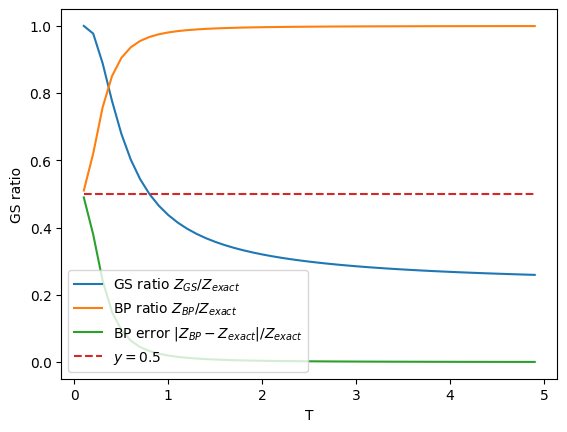

In [6]:
# plot the Z-T curve
import matplotlib.pyplot as plt
GS_ratio_list = np.array(GS_slices_list)/np.array(Exact_Z_list)
BP_ratio_list = np.array(BP_Z_list)/np.array(Exact_Z_list)
BP_error_list = np.abs(np.array(BP_Z_list)-np.array(Exact_Z_list))/np.array(Exact_Z_list)
# plt.plot(T_list,BP_Z_list,label='BP')
# plt.plot(T_list,Exact_Z_list,label='Exact')
# plt.plot(T_list,GS_slices_list,label='GS slices')
plt.plot(T_list,GS_ratio_list,label=r'GS ratio $Z_{GS}/Z_{exact}$')
plt.plot(T_list,BP_ratio_list,label=r'BP ratio $Z_{BP}/Z_{exact}$')
plt.plot(T_list,BP_error_list,label=r'BP error $|Z_{BP}-Z_{exact}|/Z_{exact}$')
# plot y=0.5 line
plt.plot(T_list,0.5*np.ones(len(T_list)),label=r'$y=0.5$',linestyle='--')
plt.xlabel('T')
plt.ylabel('GS ratio')
plt.legend()
plt.show()

In [54]:
messages

{(0, 's0'): array([0.67465472, 0.32534528]),
 (3, 's0'): array([0.48223969, 0.51776031]),
 (0, 's1'): array([0.67465472, 0.32534528]),
 (1, 's1'): array([0.48223969, 0.51776031]),
 (1, 's2'): array([0.48223969, 0.51776031]),
 (2, 's2'): array([0.67465472, 0.32534528]),
 (2, 's3'): array([0.67465472, 0.32534528]),
 (3, 's3'): array([0.48223969, 0.51776031]),
 ('s0', 0): array([0.48223969, 0.51776031]),
 ('s1', 0): array([0.48223969, 0.51776031]),
 ('s1', 1): array([0.67465472, 0.32534528]),
 ('s2', 1): array([0.67465472, 0.32534528]),
 ('s2', 2): array([0.48223969, 0.51776031]),
 ('s3', 2): array([0.48223969, 0.51776031]),
 ('s3', 3): array([0.67465472, 0.32534528]),
 ('s0', 3): array([0.67465472, 0.32534528])}

In [3]:
qbp.compute_all_index_marginals_from_messages(tn, messages)

{'s0': array([1.00000000e+00, 5.06765583e-48]),
 's1': array([1.01346215e-47, 1.00000000e+00]),
 's2': array([1.01346215e-47, 1.00000000e+00]),
 's3': array([1.00000000e+00, 5.06765583e-48])}